In [2]:
#All the required imports
import requests
import json
from pymongo import MongoClient
import pandas as pd
import datetime as dt
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import psycopg2
import csv
import numpy as np
import datetime as dt
import plotly.express as px
import pandas as pd
import altair as alt
from random import sample

In [3]:
#Take input from the user for the year and accordingly fetch the data from API
baseurl = "https://data.cityofnewyork.us/resource/8h9b-rp9u.json?$$app_token=wK7SaysF0k1J53sWS6fKyaxT0"
# year based on input 
count_url = "&$select=count(arrest_key)"
year = input("Please type the year for which analysis to be done. The year should be between 2012 to 2018.")
year_url = "&$where=arrest_date between '"+ str(int(year)-1)+ "-12-31T12:00:00' and '" + str(year) + "-12-31T14:00:00'"
#year_url = "&$where=date_extract_y(SUMMONS_DATE) in (" + year + ")"
print (baseurl + year_url + count_url)

Please type the year for which analysis to be done. The year should be between 2012 to 2018.2018
https://data.cityofnewyork.us/resource/8h9b-rp9u.json?$$app_token=wK7SaysF0k1J53sWS6fKyaxT0&$where=arrest_date between '2017-12-31T12:00:00' and '2018-12-31T14:00:00'&$select=count(arrest_key)


In [6]:
#Fetch count of existing records from API.
try:
    urlfinal = baseurl + year_url + count_url
    response = requests.get(urlfinal)
    arrests_count = json.loads(response.text)
    total_count = arrests_count[0]['count_arrest_key']
except:
    print(response.status_code)
    print("Error in fetching data from API. Data not found.")


#Retrieveing all the data for the year.
limit_url = "&$limit="+str(total_count)

#Connect to MongoDB
mdb_client = MongoClient("mongodb://localhost:27017/")
#Create Database
project_db = mdb_client["NewYorkData"]
#Create Collection
arrests_col = project_db["ArrestsCollection"]

#If records already present in MongoDB. Cleaning up the previous records.
existing_records_count = arrests_col.find().count()
if (existing_records_count > 0):
    arrests_col.remove()


page_url = baseurl+year_url+limit_url
page_response = requests.get(page_url)
arrests_data = json.loads(page_response.text)
#Count the number of records fetched from API
fetched_records_count = len(arrests_data)
print(fetched_records_count)
#Insert data to the ArrestsCollection
inserted_records = arrests_col.insert_many(arrests_data)
inserted_records_count = len(inserted_records.inserted_ids)
print(fetched_records_count == inserted_records_count)

#Check count of inserted records
inserted_count = arrests_col.find().count()
print(inserted_count)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DeprecationWarning:

count is deprecated. Use Collection.count_documents instead.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning:

remove is deprecated. Use delete_one or delete_many instead.



246773
True
246773


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: DeprecationWarning:

count is deprecated. Use Collection.count_documents instead.



In [9]:
"NewYorkData" in mdb_client.list_database_names() # Validating database was created
"ArrestsCollection" in project_db.list_collection_names() # Validating collection was created

True

In [41]:
#Connect to MongoDB
mdb_client = MongoClient("mongodb://localhost:27017/")
#Create Database
project_db = mdb_client["NewYorkData"]
#Create Collection
arrests_col = project_db["ArrestsCollection"]
#Fetching data from MongoDB and converting into DataFrame.
arrest_data = pd.DataFrame(list(arrests_col.find()))

In [42]:
#Create Dataframe for Borough
#Create A New Dataframe
dict = {'arrest_boro':["S", "K","B", "Q", "M"], 
        'boro_nm': ["STATEN ISLAND", "BROOKLYN", "BRONX", "QUEENS", "MANHATTAN"]} 
boro_df = pd.DataFrame(dict)
print(boro_df)
arrest_data = pd.merge(arrest_data, 
                       boro_df[['arrest_boro','boro_nm']],
                       on ='arrest_boro',
                       how='left')
temp_boro = pd.DataFrame()
temp_boro['boro_nm']=arrest_data['boro_nm']
arrest_data['arrest_boro']=temp_boro['boro_nm']

  arrest_boro        boro_nm
0           S  STATEN ISLAND
1           K       BROOKLYN
2           B          BRONX
3           Q         QUEENS
4           M      MANHATTAN


In [43]:
### Cleaning arrest data ##########
## As a very small percentage of our data is missing, just dropping those columns
arrest_data = arrest_data.dropna()

#dropping the autogenerated id and arrest_key field from dataframe
arrest_data.drop(['_id','x_coord_cd','y_coord_cd','boro_nm'], axis=1, inplace=True)

#converting datatype of arrest_date to pythons date-time object
arrest_data['arrest_date'] = pd.to_datetime(arrest_data.arrest_date)

# For columns 'law_cat_cd' mentions only 3 values, however, there is another 
#value in the dataset which could be a mistake, so removing it
arrest_data = arrest_data.loc[arrest_data['law_cat_cd'] != 'I']

# Exporting Cleaned data to csv
arrest_data.to_csv ('arrest_data.csv', index = None, header=True)

In [39]:
#Create tables
try:
    dbConnection = psycopg2.connect(
    user = "postgres",
    password = "dublin",
    host = "127.0.0.1",
    port = "5432",
    database = "newyorkdata")
    dbConnection.set_isolation_level(0) # AUTOCOMMIT
    dbCursor = dbConnection.cursor()
    dbCursor.execute("""
                     CREATE TABLE Arrests(
                            arrest_key varchar(20) PRIMARY KEY,
                            arrest_date date,
                            pd_cd varchar(50),
                            pd_desc varchar(50),
                            ky_cd varchar(50),
                            ofns_desc varchar(50),
                            law_code varchar(50), 
                            law_cat_cd varchar(50), 
                            arrest_boro varchar(50), 
                            arrest_precinct varchar(50),
                            jurisdiction_code varchar(50), 
                            age_group varchar(50), 
                            perp_sex varchar(50), 
                            perp_race varchar(50), 
                            latitude varchar(50),
                            longitude varchar(50)
                             );
                    """)
    dbCursor.close()
except (Exception , psycopg2.Error) as dbError :
    print ("Error while connecting to PostgreSQL", dbError)
finally:
    if(dbConnection): dbConnection.close()
   

In [40]:
#Insert data to postgres
try:
    dbConnection = psycopg2.connect(
    user = "postgres",
    password = "dublin",
    host = "127.0.0.1",
    port = "5432",
    database = "newyorkdata")
    dbConnection.set_isolation_level(0) # AUTOCOMMIT
    dbCursor = dbConnection.cursor()
    with open ('arrest_data.csv', 'r') as f:
        reader = csv.reader(f)
        next(reader) # Skip the header row.
        for row in reader:
            dbCursor.execute(
            "INSERT INTO arrests VALUES (%s, %s,%s, %s,%s, %s,%s, %s,%s, %s,%s, %s,%s, %s,%s, %s)",
            row
        )
    dbConnection.commit()
    dbCursor.close()
except (Exception , psycopg2.Error) as dbError :
    print ("Error while connecting to PostgreSQL", dbError)
finally:
    if(dbConnection): dbConnection.close()

In [47]:
complaints_data = pd.read_csv("complaint.csv") 
#arrest_data = pd.read_csv("arrest_data.csv") 
summons_data =  pd.read_csv("courtsummon.csv")

In [50]:
prison_data = pd.read_csv("PrisonAdmissions.csv")

In [51]:
## Concatinating data from all the dataframes by month
arrest_by_month = arrest_data.arrest_date.dt.month.value_counts().sort_index()
complaints_by_month = complaints_data.cmplnt_fr_dt.dt.month.value_counts().sort_index()
summons_by_month = summons_data.summons_date.dt.month.value_counts().sort_index()
prison_by_month = prison_data.MonthCode.value_counts().sort_index()

month_data = pd.concat([arrest_by_month,complaints_by_month,summons_by_month,prison_by_month],axis=1)
month_data.rename({'arrest_date': 'Arrests', 'cmplnt_fr_dt': 'Complaints','summons_date':'Summons','MonthCode':'Prison'}, axis=1, inplace=True)
#month_data.plot(kind='line')

arrest_by_month.rename(index = {1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',
                          11:'Nov',12:'Dec'},inplace = True)
complaints_by_month.rename(index = {1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',
                          11:'Nov',12:'Dec'},inplace = True)
summons_by_month.rename(index = {1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',
                          11:'Nov',12:'Dec'},inplace = True)
prison_by_month.rename(index = {1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',
                          11:'Nov',12:'Dec'},inplace = True)

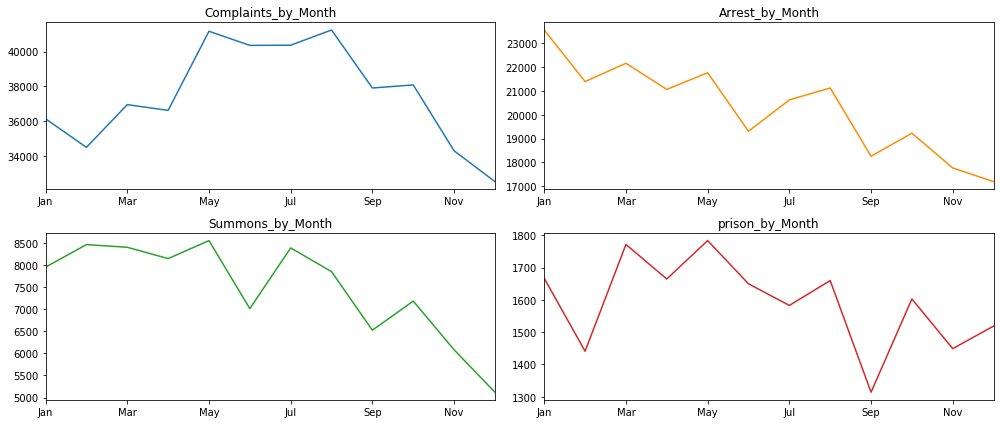

In [59]:
fig, ax = plt.subplots(2, 2,figsize = (14,6))
complaints_by_month.plot("line", ax=ax[0,0]).set_title('Complaints_by_Month')
arrest_by_month.plot("line", ax=ax[0,1],color='#ff8c00').set_title('Arrest_by_Month')
summons_by_month.plot("line", ax=ax[1,0],color = '#2ca02c').set_title('Summons_by_Month')
prison_by_month.plot("line", ax=ax[1,1],color = '#d62728').set_title('prison_by_Month')
plt.tight_layout()
plt.show()

,Complaints,Arrests,Summons,Prison
BRONX,0.070349,0.038283,0.016075,0.000811
BROOKLYN,0.051380,0.026182,0.008850,0.000499
MANHATTAN,0.067222,0.037696,0.015533,0.001606
QUEENS,0.038020,0.021637,0.006435,0.000518
STATEN ISLAND,0.043314,0.021673,0.008022,0.000477


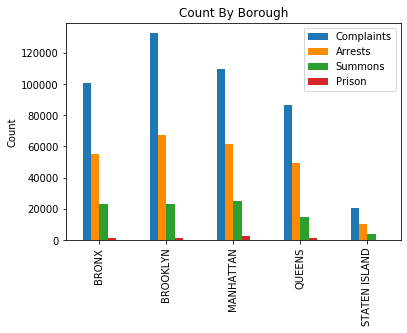

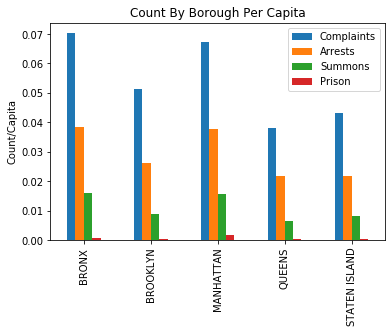

In [203]:
### Plotting data by Boruoughs
arrest_boro = arrest_data.arrest_boro.value_counts()
arrest_boro.rename(index = {'K':'BROOKLYN','B':'BRONX','Q':'QUEENS','M':'MANHATTAN','S':'STATEN ISLAND'}, inplace=True)
comp_boro = complaints_data.boro_nm.value_counts()
summon_boro = summons_data.boro.value_counts()
summon_boro.rename(index = {'NEW YORK':'MANHATTAN'},inplace=True)
prison_boro = prison_data.Borough.value_counts()

#boro = pd.merge(arrest_boro, comp_boro, left_index=True, right_index=True)
boro = pd.concat([comp_boro,arrest_boro,summon_boro,prison_boro], axis=1, sort=True)
boro.rename({'arrest_boro': 'Arrests', 'boro_nm': 'Complaints','boro':'Summons','Borough':'Prison'}, axis=1, inplace=True)
boro.plot.bar(color = ('#1f77b4','#ff8c00','#2ca02c','#d62728')).set_title('Count By Borough')
plt.ylabel('Count')

boro.div(pop['Pop2018'],axis=0).plot.bar().set_title('Count By Borough Per Capita')
plt.ylabel('Count/Capita')

boro.div(pop['Pop2018'],axis=0)

In [557]:
arrest_data.head(10)

,arrest_key,arrest_date,pd_cd,pd_desc,ky_cd,ofns_desc,law_code,law_cat_cd,arrest_boro,arrest_precinct,jurisdiction_code,age_group,perp_sex,perp_race,x_coord_cd,y_coord_cd,latitude,longitude
0,173130593,2018-01-01,567.0,"MARIJUANA, POSSESSION 4 & 5",235.0,DANGEROUS DRUGS,PL 2211001,M,K,79,0,25-44,M,BLACK,998109,194098,40.699428,-73.950020
1,173130604,2018-01-01,905.0,"INTOXICATED DRIVING,ALCOHOL",347.0,INTOXICATED & IMPAIRED DRIVING,VTL11920U2,M,S,121,0,25-44,M,WHITE,937282,165404,40.620556,-74.169188
2,173145866,2018-01-01,461.0,UNAUTHORIZED USE VEHICLE 2,126.0,MISCELLANEOUS PENAL LAW,PL 1650600,F,B,49,0,18-24,F,BLACK,1027430,251105,40.855803,-73.843910
3,173134305,2018-01-01,101.0,ASSAULT 3,344.0,ASSAULT 3 & RELATED OFFENSES,PL 1200001,M,B,46,0,45-64,M,BLACK,1005725,249742,40.852141,-73.922376
4,173134161,2018-01-01,905.0,"INTOXICATED DRIVING,ALCOHOL",347.0,INTOXICATED & IMPAIRED DRIVING,VTL11920U2,M,Q,113,0,25-44,M,BLACK,1041984,182948,40.668647,-73.791884
5,173134130,2018-01-01,681.0,"CHILD, ENDANGERING WELFARE",233.0,SEX CRIMES,PL 2601001,M,B,43,0,25-44,F,WHITE HISPANIC,1020316,239179,40.823101,-73.869690
6,173149747,2018-01-01,922.0,"TRAFFIC,UNCLASSIFIED MISDEMEAN",348.0,VEHICLE AND TRAFFIC LAWS,VTL0511001,M,M,33,0,25-44,M,WHITE HISPANIC,1001603,246944,40.844471,-73.937283
7,173148127,2018-01-01,114.0,OBSTR BREATH/CIRCUL,344.0,ASSAULT 3 & RELATED OFFENSES,PL 1211100,M,M,25,0,25-44,M,BLACK,1001575,232339,40.804384,-73.937422
8,173148123,2018-01-01,922.0,"TRAFFIC,UNCLASSIFIED MISDEMEAN",348.0,VEHICLE AND TRAFFIC LAWS,VTL0511001,M,M,23,0,25-44,M,WHITE HISPANIC,999769,228033,40.792569,-73.943955
9,173148115,2018-01-01,397.0,"ROBBERY,UNCLASSIFIED,OPEN AREAS",105.0,ROBBERY,PL 160102A,F,K,61,0,18-24,M,BLACK HISPANIC,995118,155709,40.594063,-73.960869


In [556]:
summons_data.head(10)

,summons_key,summons_date,offense_description,law_section_number,age_group,sex,race,jurisdiction_code,boro,precinct_of_occur,x_coordinate_cd,y_coordinate_cd,latitude,longitude
0,174350856,2018-01-01,OTHER ACA,9999,18-24,M,ASIAN / PACIFIC ISLANDER,0,QUEENS,114,1005141,216757,40.761608,-73.924589
1,173303103,2018-01-01,TRESPASS,140.05,18-24,M,WHITE,0,NEW YORK,19,997016,225727,40.786244,-73.953902
2,173249490,2018-01-01,UNLICENSED VEHICLE FOR HIRE,19-506,45-64,M,BLACK,0,BROOKLYN,70,994496,175887,40.649448,-73.963078
3,173205994,2018-01-01,"MARIJUANA, POSSESSION OF",221.05,18-24,F,BLACK,0,QUEENS,105,1066784,213480,40.752253,-73.702112
4,173205905,2018-01-01,OTHER VTL,9999,25-44,M,BLACK HISPANIC,0,NEW YORK,34,1002455,250128,40.853208,-73.934195
5,173205915,2018-01-01,EXPOSURE OF PERSON,245.01,18-24,F,BLACK HISPANIC,0,BRONX,47,1020808,262493,40.887089,-73.867786
6,173205937,2018-01-01,DISORDERLY CONDUCT,240.2,18-24,F,BLACK,2,QUEENS,114,1002494,216454,40.760782,-73.934145
7,173303147,2018-01-01,OTHER VTL,9999,45-64,M,BLACK HISPANIC,0,BRONX,44,1004687,239413,40.823794,-73.926159
8,173205962,2018-01-01,KEY IN IGNITION,10-111,25-44,M,AMERICAN INDIAN/ALASKAN NATIVE,0,BROOKLYN,77,1000435,185274,40.675204,-73.941653
9,173249492,2018-01-01,ACCEPT ON HAIL,19-507,45-64,M,BLACK,0,BROOKLYN,70,994496,175887,40.649448,-73.963078


In [621]:
complaints_data.head()

,cmplnt_num,cmplnt_fr_dt,cmplnt_fr_tm,addr_pct_cd,rpt_dt,ky_cd,ofns_desc,pd_cd,pd_desc,crm_atpt_cptd_cd,...,latitude,longitude,lat_lon,patrol_boro,vic_age_group,vic_race,vic_sex,susp_age_group,susp_race,susp_sex
0,228818877,2018-02-13,17:00:00,122,2018-02-14T00:00:00.000,107,BURGLARY,223.0,"BURGLARY,RESIDENCE,NIGHT",COMPLETED,...,40.577295,-74.140571,"{'latitude': '40.577295244', 'longitude': '-74...",PATROL BORO STATEN ISLAND,UNKNOWN,UNKNOWN,D,25-44,WHITE HISPANIC,M
1,340031034,2018-06-07,23:30:00,73,2018-06-08T00:00:00.000,344,ASSAULT 3 & RELATED OFFENSES,101.0,ASSAULT 3,COMPLETED,...,40.663056,-73.910971,"{'latitude': '40.663055675', 'longitude': '-73...",PATROL BORO BKLYN NORTH,18-24,BLACK,F,25-44,WHITE HISPANIC,M
2,369826765,2018-05-20,01:45:00,47,2018-05-20T00:00:00.000,106,FELONY ASSAULT,109.0,"ASSAULT 2,1,UNCLASSIFIED",COMPLETED,...,40.887314,-73.847272,"{'latitude': '40.887313634', 'longitude': '-73...",PATROL BORO BRONX,25-44,BLACK,M,25-44,BLACK HISPANIC,F
5,110699092,2018-03-01,12:00:00,105,2018-03-05T00:00:00.000,118,DANGEROUS WEAPONS,793.0,WEAPONS POSSESSION 3,COMPLETED,...,40.661808,-73.768199,"{'latitude': '40.661808072', 'longitude': '-73...",PATROL BORO QUEENS SOUTH,25-44,BLACK,M,25-44,WHITE HISPANIC,F
6,771385512,2018-04-07,00:55:00,44,2018-04-07T00:00:00.000,107,BURGLARY,243.0,"BURGLARY,UNCLASSIFIED,NIGHT",COMPLETED,...,40.830354,-73.923276,"{'latitude': '40.830354282', 'longitude': '-73...",PATROL BORO BRONX,UNKNOWN,UNKNOWN,D,25-44,WHITE,F


In [20]:
prison_data.head()

,Unnamed: 0,AdmissionYear,AdmissionMonth,MonthCode,AdmissionType,CountyOfCommitment,LastKnownResidenceCounty,Gender,AgeOfAdmission,MostSeriousCrime,AgeRange,Borough
0,0,2018,JANUARY,1,NEW COURT COMMITMENT,BRONX,MISSING,MALE,40,CPCS 3RD,25-44,BRONX
51,51,2018,JANUARY,1,NEW COURT COMMITMENT,BRONX,MISSING,MALE,17,C POS WEAPON 2ND,< 18,BRONX
52,52,2018,JANUARY,1,NEW COURT COMMITMENT,BRONX,MISSING,MALE,17,YO ASSAULT,< 18,BRONX
53,53,2018,JANUARY,1,NEW COURT COMMITMENT,BRONX,MISSING,MALE,18,YO MURDER,< 18,BRONX
54,54,2018,JANUARY,1,NEW COURT COMMITMENT,BRONX,MISSING,MALE,19,ASSAULT 2ND,18-24,BRONX


In [19]:
prison_data= prison_data.dropna()
prison_data.Borough.unique()

array(['BRONX', 'BROOKLYN', 'MANHATTAN', 'QUEENS', 'STATEN ISLAND'],
      dtype=object)

In [52]:
## Multi stacked bar plot
arrest_age_boro = pd.crosstab(arrest_data.arrest_boro,arrest_data.age_group)
arrest_age_boro.rename(index = {'K':'BROOKLYN','B':'BRONX',
                            'Q':'QUEENS','M':'MANHATTAN','S':'STATEN ISLAND'}, inplace=True)
comp_age_boro = pd.crosstab(complaints_data.boro_nm,complaints_data.susp_age_group)
summon_age_boro = pd.crosstab(summons_data.boro,summons_data.age_group)
summon_age_boro.rename(index = {'NEW YORK':'MANHATTAN'},inplace=True)
prison_age_boro = pd.crosstab(prison_data.Borough,prison_data.AgeRange)
prison_age_boro.rename(columns = {'< 18':'<18'}, inplace=True)

def prep_df(df, name):
    df = df.stack().reset_index()
    df.columns = ['c1', 'c2', 'values']
    df['DF'] = name
    return df

df1 = prep_df(arrest_age_boro, 'Arrest')
df2 = prep_df(comp_age_boro, 'Complaints')
df3 = prep_df(summon_age_boro, 'Court Summons')
df4 = prep_df(prison_age_boro, 'Prison')

df = pd.concat([df1, df2, df3, df4])


alt.Chart(df).mark_bar().encode(

    # tell Altair which field to group columns on
    x=alt.X('c2:N', title=None),

    # tell Altair which field to use as Y values and how to calculate
    y=alt.Y('sum(values):Q',
        axis=alt.Axis(
            grid=False)),

    # tell Altair which field to use to use as the set of columns to be  represented in each group
    column=alt.Column('c1:N', title=None,header= alt.Header(title = 'Crimes by Age Group and Borough')),
    
    order=alt.Order(
      # Sort the segments of the bars by this field
      'values',
      sort='descending'),

    # tell Altair which field to use for color segmentation 
    color=alt.Color('DF:N',
            scale=alt.Scale(
                # make it look pretty with an enjoyable color pallet
                range=['#ff8c00','#1f77b4', '#2ca02c','#d62728']
            ),
        ))\
    .configure_view(
        # remove grid lines around column clusters
        strokeOpacity=0    
    )

<VegaLite 3 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/troubleshooting.html


In [62]:
## Multi stacked bar plot
arrest_sex_boro = pd.crosstab(arrest_data.arrest_boro,arrest_data.perp_sex)
arrest_sex_boro.rename(index = {'K':'BROOKLYN','B':'BRONX',
                            'Q':'QUEENS','M':'MANHATTAN','S':'STATEN ISLAND'}, inplace=True)
comp_sex_boro = pd.crosstab(complaints_data.boro_nm,complaints_data.susp_sex)
summon_sex_boro = pd.crosstab(summons_data.boro,summons_data.sex)
summon_sex_boro.rename(index = {'NEW YORK':'MANHATTAN'},inplace=True)
prison_sex_boro = pd.crosstab(prison_data.Borough,prison_data.Gender)
prison_sex_boro.rename(columns = {'FEMALE':'F', 'MALE':'M'}, inplace=True)


def prep_df(df, name):
    df = df.stack().reset_index()
    df.columns = ['c1', 'c2', 'values']
    df['DF'] = name
    return df

df1 = prep_df(arrest_sex_boro, 'Arrest')
df2 = prep_df(comp_sex_boro, 'Complaints')
df3 = prep_df(summon_sex_boro, 'Court Summons')
df4 = prep_df(prison_sex_boro, 'Prison')

df = pd.concat([df1, df2, df3, df4])

alt.Chart(df).mark_bar().encode(

    # tell Altair which field to group columns on
    x=alt.X('c2:N', title=None),

    # tell Altair which field to use as Y values and how to calculate
    y=alt.Y('sum(values):Q',
        axis=alt.Axis(
            grid=False
            )),

    # tell Altair which field to use to use as the set of columns to be  represented in each group
    column=alt.Column('c1:N', title=None,header= alt.Header(title = 'Crimes by Gender and Borough')),
    
    order=alt.Order(
      # Sort the segments of the bars by this field
      'values',
      sort='descending'
    ),

    # tell Altair which field to use for color segmentation 
    color = alt.Color('DF:N',
            scale=alt.Scale(
                # make it look pretty with an enjoyable color pallet
               range=['#ff8c00','#1f77b4', '#2ca02c','#d62728'])
            ),
        )\
    .configure_view(
        # remove grid lines around column clusters
        strokeOpacity=0    
    )

alt.Chart(...)